# **Hotel Cancel Culture** - **EDA Notebook**

---

**Author:** Ben McCarty

**Capstone Project** - Predicting hotel reservation cancellations.

**Contact:** bmccarty505@gmail.com

---

**Of Demands and Cancellations**

>**Every aspect of hospitality depends on accurately anticipating business demand**: how many rooms to clean; how many rooms are available to sell; what would be the best rate; and how to bring it all together to make every guest satisfied. 
>
> Proper forecasting is critical to every department and staff member, and to generate our forecasts, **hotel managers need to know how many guests will cancel prior to arrival**. Using data from two European hotels, I developed a model to predict whether a given reservation would cancel based on 30 different reservation details.

**In order to develop and train my models, I need to prepare the data in advance.**

>In this notebook, I explore the original dataset and its features; condense several features into smaller subsets; engineer new features; and remove unwanted features from the data.
>
**Once the data is prepared, I will reload the data in a new notebook to create and train my models to determine my predictions of who will stay and who will cancel.**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hotel-Cancel-Culture---EDA-Notebook" data-toc-modified-id="Hotel-Cancel-Culture---EDA-Notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><strong>Hotel Cancel Culture</strong> - <strong>EDA Notebook</strong></a></span></li><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><strong>Import Packages</strong></a></span></li><li><span><a href="#Read-Data" data-toc-modified-id="Read-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><strong>Read Data</strong></a></span></li><li><span><a href="#Identifying-Target-Feature" data-toc-modified-id="Identifying-Target-Feature-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><strong>Identifying Target Feature</strong></a></span></li><li><span><a href="#Reviewing-Statistics" data-toc-modified-id="Reviewing-Statistics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span><strong>Reviewing Statistics</strong></a></span></li><li><span><a href="#Processing-Missing-Values" data-toc-modified-id="Processing-Missing-Values-6"><span class="toc-item-num">6&nbsp;&nbsp;</span><strong>Processing Missing Values</strong></a></span><ul class="toc-item"><li><span><a href="#Dropping-Company-Column" data-toc-modified-id="Dropping-Company-Column-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Dropping <code>Company</code> Column</a></span></li><li><span><a href="#Filling-Missing-Values-for-Country-and-Children" data-toc-modified-id="Filling-Missing-Values-for-Country-and-Children-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Filling Missing Values for <code>Country</code> and <code>Children</code></a></span></li></ul></li><li><span><a href="#EDA---Features" data-toc-modified-id="EDA---Features-7"><span class="toc-item-num">7&nbsp;&nbsp;</span><strong>EDA - Features</strong></a></span><ul class="toc-item"><li><span><a href="#Toggle-Visualizations" data-toc-modified-id="Toggle-Visualizations-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span><strong>Toggle Visualizations</strong></a></span></li><li><span><a href="#Is_Canceled" data-toc-modified-id="Is_Canceled-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span><code>Is_Canceled</code></a></span></li><li><span><a href="#Reservation_Status" data-toc-modified-id="Reservation_Status-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span><code>Reservation_Status</code></a></span></li><li><span><a href="#Lead_Time" data-toc-modified-id="Lead_Time-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span><code>Lead_Time</code></a></span></li><li><span><a href="#Arrival_Date_Year" data-toc-modified-id="Arrival_Date_Year-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span><code>Arrival_Date_Year</code></a></span></li><li><span><a href="#Stays_in_Weekend_Nights" data-toc-modified-id="Stays_in_Weekend_Nights-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span><code>Stays_in_Weekend_Nights</code></a></span></li><li><span><a href="#Stays_in_Week_Nights" data-toc-modified-id="Stays_in_Week_Nights-7.7"><span class="toc-item-num">7.7&nbsp;&nbsp;</span><code>Stays_in_Week_Nights</code></a></span></li><li><span><a href="#Adults" data-toc-modified-id="Adults-7.8"><span class="toc-item-num">7.8&nbsp;&nbsp;</span><code>Adults</code></a></span></li><li><span><a href="#Children" data-toc-modified-id="Children-7.9"><span class="toc-item-num">7.9&nbsp;&nbsp;</span><code>Children</code></a></span></li><li><span><a href="#Babies" data-toc-modified-id="Babies-7.10"><span class="toc-item-num">7.10&nbsp;&nbsp;</span><code>Babies</code></a></span></li><li><span><a href="#Meal" data-toc-modified-id="Meal-7.11"><span class="toc-item-num">7.11&nbsp;&nbsp;</span><code>Meal</code></a></span></li><li><span><a href="#Country" data-toc-modified-id="Country-7.12"><span class="toc-item-num">7.12&nbsp;&nbsp;</span><code>Country</code></a></span></li><li><span><a href="#Market_Segment" data-toc-modified-id="Market_Segment-7.13"><span class="toc-item-num">7.13&nbsp;&nbsp;</span><code>Market_Segment</code></a></span></li><li><span><a href="#Distribution_Channel" data-toc-modified-id="Distribution_Channel-7.14"><span class="toc-item-num">7.14&nbsp;&nbsp;</span><code>Distribution_Channel</code></a></span></li><li><span><a href="#Is_Repeated_Guest" data-toc-modified-id="Is_Repeated_Guest-7.15"><span class="toc-item-num">7.15&nbsp;&nbsp;</span><code>Is_Repeated_Guest</code></a></span></li><li><span><a href="#Previous_Cancellations" data-toc-modified-id="Previous_Cancellations-7.16"><span class="toc-item-num">7.16&nbsp;&nbsp;</span><code>Previous_Cancellations</code></a></span></li><li><span><a href="#Previous_Bookings_Not_Canceled" data-toc-modified-id="Previous_Bookings_Not_Canceled-7.17"><span class="toc-item-num">7.17&nbsp;&nbsp;</span><code>Previous_Bookings_Not_Canceled</code></a></span></li><li><span><a href="#Reserved_Room_Type" data-toc-modified-id="Reserved_Room_Type-7.18"><span class="toc-item-num">7.18&nbsp;&nbsp;</span><code>Reserved_Room_Type</code></a></span></li><li><span><a href="#Assigned_Room_Type" data-toc-modified-id="Assigned_Room_Type-7.19"><span class="toc-item-num">7.19&nbsp;&nbsp;</span><code>Assigned_Room_Type</code></a></span></li><li><span><a href="#Booking_Changes" data-toc-modified-id="Booking_Changes-7.20"><span class="toc-item-num">7.20&nbsp;&nbsp;</span><code>Booking_Changes</code></a></span></li><li><span><a href="#Deposit_Type" data-toc-modified-id="Deposit_Type-7.21"><span class="toc-item-num">7.21&nbsp;&nbsp;</span><code>Deposit_Type</code></a></span></li><li><span><a href="#Days_in_Waiting_List" data-toc-modified-id="Days_in_Waiting_List-7.22"><span class="toc-item-num">7.22&nbsp;&nbsp;</span><code>Days_in_Waiting_List</code></a></span></li><li><span><a href="#Customer_Type" data-toc-modified-id="Customer_Type-7.23"><span class="toc-item-num">7.23&nbsp;&nbsp;</span><code>Customer_Type</code></a></span></li><li><span><a href="#ADR" data-toc-modified-id="ADR-7.24"><span class="toc-item-num">7.24&nbsp;&nbsp;</span><code>ADR</code></a></span></li><li><span><a href="#Required_Car_Parking_Spaces" data-toc-modified-id="Required_Car_Parking_Spaces-7.25"><span class="toc-item-num">7.25&nbsp;&nbsp;</span><code>Required_Car_Parking_Spaces</code></a></span></li><li><span><a href="#Total_of_Special_Requests" data-toc-modified-id="Total_of_Special_Requests-7.26"><span class="toc-item-num">7.26&nbsp;&nbsp;</span><code>Total_of_Special_Requests</code></a></span></li><li><span><a href="#Reservation_Status_Date" data-toc-modified-id="Reservation_Status_Date-7.27"><span class="toc-item-num">7.27&nbsp;&nbsp;</span><code>Reservation_Status_Date</code></a></span></li><li><span><a href="#Agent" data-toc-modified-id="Agent-7.28"><span class="toc-item-num">7.28&nbsp;&nbsp;</span><code>Agent</code></a></span></li></ul></li><li><span><a href="#Post-EDA-Updates" data-toc-modified-id="Post-EDA-Updates-8"><span class="toc-item-num">8&nbsp;&nbsp;</span><strong>Post-EDA Updates</strong></a></span><ul class="toc-item"><li><span><a href="#Condensing-Features" data-toc-modified-id="Condensing-Features-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Condensing Features</a></span><ul class="toc-item"><li><span><a href="#Condensing-Meal" data-toc-modified-id="Condensing-Meal-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>Condensing <code>Meal</code></a></span></li><li><span><a href="#Condensing-Agent-into-Agent_Group" data-toc-modified-id="Condensing-Agent-into-Agent_Group-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>Condensing <code>Agent</code> into <code>Agent_Group</code></a></span></li><li><span><a href="#Condensing-Country-Categories" data-toc-modified-id="Condensing-Country-Categories-8.1.3"><span class="toc-item-num">8.1.3&nbsp;&nbsp;</span>Condensing <code>Country</code> Categories</a></span></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Engineering-Arrival_Date" data-toc-modified-id="Engineering-Arrival_Date-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Engineering <code>Arrival_Date</code></a></span></li><li><span><a href="#Engineering-Stay-Length" data-toc-modified-id="Engineering-Stay-Length-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>Engineering <code>Stay Length</code></a></span></li></ul></li><li><span><a href="#Dropping-Features" data-toc-modified-id="Dropping-Features-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Dropping Features</a></span><ul class="toc-item"><li><span><a href="#Dropping-&quot;Undefined&quot;-from-Market_Segment" data-toc-modified-id="Dropping-&quot;Undefined&quot;-from-Market_Segment-8.3.1"><span class="toc-item-num">8.3.1&nbsp;&nbsp;</span>Dropping "Undefined" from <code>Market_Segment</code></a></span></li><li><span><a href="#Comparing-Market_Segment-and-Distribution_Channel" data-toc-modified-id="Comparing-Market_Segment-and-Distribution_Channel-8.3.2"><span class="toc-item-num">8.3.2&nbsp;&nbsp;</span>Comparing <code>Market_Segment</code> and <code>Distribution_Channel</code></a></span></li><li><span><a href="#Dropping-Reservation_Status" data-toc-modified-id="Dropping-Reservation_Status-8.3.3"><span class="toc-item-num">8.3.3&nbsp;&nbsp;</span>Dropping <code>Reservation_Status</code></a></span></li><li><span><a href="#Dropping-Arrival_Date_Year" data-toc-modified-id="Dropping-Arrival_Date_Year-8.3.4"><span class="toc-item-num">8.3.4&nbsp;&nbsp;</span>Dropping <code>Arrival_Date_Year</code></a></span></li><li><span><a href="#Dropping-Reservation_Status_Date" data-toc-modified-id="Dropping-Reservation_Status_Date-8.3.5"><span class="toc-item-num">8.3.5&nbsp;&nbsp;</span>Dropping <code>Reservation_Status_Date</code></a></span></li></ul></li><li><span><a href="#Final-Data-Review" data-toc-modified-id="Final-Data-Review-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Final Data Review</a></span></li></ul></li><li><span><a href="#Of-Pandas-and-Pickles" data-toc-modified-id="Of-Pandas-and-Pickles-9"><span class="toc-item-num">9&nbsp;&nbsp;</span><strong>Of Pandas and Pickles</strong></a></span></li><li><span><a href="#Future-Work:-EDA" data-toc-modified-id="Future-Work:-EDA-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Future Work: EDA</a></span></li><li><span><a href="#Moving-to-Modeling!" data-toc-modified-id="Moving-to-Modeling!-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Moving to Modeling!</a></span></li></ul></div>

# **Import Packages**

---

> To start off, I will import a variety of packages to assist with handling my data; creating visualizations; and reviewing statistical data.

---

In [1]:
## Data Handling
import pandas as pd
import numpy as np

## Visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## Custom-made Functions
from bmc_functions import eda

In [2]:
## Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 50)
%matplotlib inline

In [3]:
## Used to upload 
%load_ext autoreload
%autoreload 2

# **Read Data**

In [4]:
## Reading data
source = './data/hotel_bookings.pickle'
data = pd.read_pickle(source, compression = "gzip")
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,nan,nan,0,Transient,0.00,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,nan,nan,0,Transient,0.00,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,nan,nan,0,Transient,75.00,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.00,nan,0,Transient,75.00,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,nan,0,Transient,98.00,0,1,Check-Out,7/3/2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.00,nan,0,Transient,96.14,0,0,Check-Out,9/6/2017
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.00,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.00,nan,0,Transient,225.43,0,2,Check-Out,9/7/2017
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.00,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.00,nan,0,Transient,157.71,0,4,Check-Out,9/7/2017
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.00,nan,0,Transient,104.40,0,0,Check-Out,9/7/2017


# **Identifying Target Feature**

---

> For my classification analysis, **I will use the `is_canceled` feature as my target feature.** This feature indicates whether a reservation was canceled (0 = check-out, 1= canceled).
>
> There is another feature, `reservation_status`, that also looks valuable. I will compare that feature against `is_canceled` to investigate any differences between the two.

---

In [5]:
## Inspecting target feature
data['is_canceled'].describe()

count   119,390.00
mean          0.37
std           0.48
min           0.00
25%           0.00
50%           0.00
75%           1.00
max           1.00
Name: is_canceled, dtype: float64

In [6]:
## Viewing breakdown of target feature
target_breakdown = data['is_canceled'].value_counts(normalize=True, dropna=False)
target_breakdown

0   0.63
1   0.37
Name: is_canceled, dtype: float64

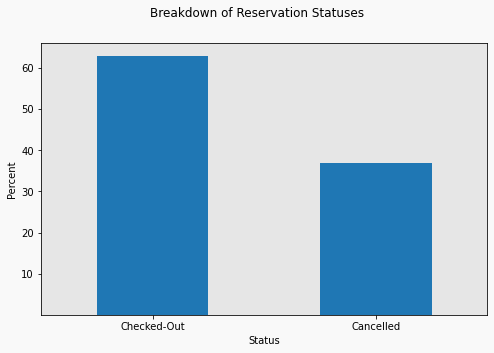

In [7]:
## Generating visualization of target feature for presentation

fig, ax = plt.subplots(figsize=(8,5))

ax = target_breakdown.plot(kind='bar',ax=ax)

ax.set(xlabel = 'Status', ylabel= 'Percent')

plt.xticks([0, 1], ['Checked-Out', 'Cancelled'], rotation=0)
plt.yticks([.1, .2, .3, .4, .5, .6], [10, 20, 30, 40, 50, 60])
plt.suptitle('Breakdown of Reservation Statuses')

ax.set_facecolor('0.9')
fig.set_facecolor('0.975')
plt.savefig('./img/cxl_stat.png',transparent=False, bbox_inches='tight',
           dpi=300)
plt.show()
plt.close()

---

**Initial Review** 

> Based on this initial review, there is a moderate class imbalance between whether a reservation canceled favoring non-canceled reservations with a 63%/37% split between not-canceled/canceled, respectively.
>
> **I will keep this imbalance in mind when I perform my modeling in my next notebook.** Imbalanced classes may have a significant negative impact on a model's performance; I will need to address the imbalance prior to modeling.

---

In [8]:
## Cleaning up memory
del target_breakdown

# **Reviewing Statistics**

---

> **To get a better idea of my overall data,** I will use a custom function that builds off of the standard `describe()` method for a dataframe. It will generate the summary statistics as well as details about the number of missing values and the datatypes for each feature.
>
>I will use Pandas's styling features to **sort and highlight the features with the largest percentage of missing values.** Missing values are my first concern and will need to be addressed first.

---

In [9]:
## Sorting report by number of missing values
eda.report_df(data).sort_values('null_sum', ascending=False).style\
                                       .background_gradient(subset='null_pct')

,null_sum,null_pct,datatypes,num_unique,count,mean,std,min,25%,50%,75%,max
company,112593,0.943069,float64,352,6797.000000,189.266735,131.655015,6.000000,62.000000,179.000000,270.000000,543.000000
agent,16340,0.136862,float64,333,103050.000000,86.693382,110.774548,1.000000,9.000000,14.000000,229.000000,535.000000
country,488,0.004087,object,177,nan,nan,nan,nan,nan,nan,nan,nan
children,4,0.000034,float64,5,119386.000000,0.103890,0.398561,0.000000,0.000000,0.000000,0.000000,10.000000
adr,0,0.000000,float64,8879,119390.000000,101.831122,50.535790,-6.380000,69.290000,94.575000,126.000000,5400.000000
lead_time,0,0.000000,int64,479,119390.000000,104.011416,106.863097,0.000000,18.000000,69.000000,160.000000,737.000000
market_segment,0,0.000000,object,8,nan,nan,nan,nan,nan,nan,nan,nan
meal,0,0.000000,object,5,nan,nan,nan,nan,nan,nan,nan,nan
previous_bookings_not_canceled,0,0.000000,int64,73,119390.000000,0.137097,1.497437,0.000000,0.000000,0.000000,0.000000,72.000000
previous_cancellations,0,0.000000,int64,15,119390.000000,0.087118,0.844336,0.000000,0.000000,0.000000,0.000000,26.000000


---

**Reviewing Reports - Missing Values**

> Based on the post-split results, I see the features `company,` `agent`, `country`, and `children` are all missing values.

***Special note:*** 

>Included in the `data_details.md` file in my main repository is a note from the authors of the original article, stating that ***any missing values are intentional representations of features that were not applicable to a reservation.***
>
> I will keep this in mind as I determine how to handle these missing values in my analysis and modeling. Options would include dropping the whole feature; creating placeholder values to indicate the lack of a value for that reservation; or simply filling the missing values with the average/most frequent values.

---

**`Company` and `Agent` Features**

>* `company:` 94%
>* `agent:` 14%
>
> Due to the large number of missing values for `company`, **I will drop the `company` feature.**
>
> The `agent` feature shows a significant number of missing values while including a very large number of unique values. I will review this feature in more depth as part of my feature-by-feature analysis to determine how to prepare this feature for modeling.

**`Country` and `Children` Features**

> The remaining two features with missing values are `country` and `children`.
>
> As there are a small number of missing values in both features, I will simply fill in the missing values with the respective most frequent value for each feature. In this case, a placeholder value would not provide any substantial benefit (and could possibly hurt the performance of a model due to the additional category for this feature).

---

# **Processing Missing Values**

## Dropping `Company` Column

In [10]:
# Dropping "company" column (95% missing values)
data = data.drop(columns = ['company'])
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,nan,0,Transient,0.00,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,nan,0,Transient,0.00,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,nan,0,Transient,75.00,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.00,0,Transient,75.00,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,0,Transient,98.00,0,1,Check-Out,7/3/2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.00,0,Transient,96.14,0,0,Check-Out,9/6/2017
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.00,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.00,0,Transient,225.43,0,2,Check-Out,9/7/2017
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.00,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.00,0,Transient,157.71,0,4,Check-Out,9/7/2017
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.00,0,Transient,104.40,0,0,Check-Out,9/7/2017


In [11]:
## Confirming 'company' removal from dataframe
'company' not in data

True

## Filling Missing Values for `Country` and `Children`

---

> As there are so few missing values for the country and children features, I do not expect the imputation method to effect my future modeling results. I will impute the most frequent values for each feature for simplicity.

---

In [12]:
## Identify columns with missing data
nan_list = ['children', 'country']
nan_list

['children', 'country']

In [13]:
## Impute the most frequent value for each column
for col in nan_list:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [14]:
## Confirming there are no remaining missing values
for col in nan_list:
    display(data[col].value_counts(1, dropna=0))
    print(f'Total missing values for {col.title()}: {data[col].isna().sum()}')

0.00    0.93
1.00    0.04
2.00    0.03
3.00    0.00
10.00   0.00
Name: children, dtype: float64

Total missing values for Children: 0


PRT   0.41
GBR   0.10
FRA   0.09
ESP   0.07
DEU   0.06
      ... 
NAM   0.00
SLE   0.00
BHS   0.00
NPL   0.00
BWA   0.00
Name: country, Length: 177, dtype: float64

Total missing values for Country: 0


In [15]:
## Deleting variables to free up space
del nan_list, col

# **EDA - Features**

---

**In-Depth Feature EDA**

> Now that I reviewed my missing values and confirmed my datatypes, I will inspect the details of each of my features. For each feature, I will review the summary statistics; the value counts; and the datatype. I will start with my target feature, including my observations and future actions at the end of each feature analysis.

**Toggling Visualizations**

> There is a simple boolean variable, set at the start of this EDA process, controlling whether to show the visualizations of each feature. By default it is set to show the visualizations. 
>
> **If you experience issues with the Notebook running slowly, please disable the visualizations by changing "True" to "False" and restarting the kernel.**
>
> Additionally, you may change the `show_visualization` argument for any feature to show the visualization for that feature. Please be aware that running multiple features may result in very poor notebook performance!

---
***Styling:***

> DataFrame styling code used in `explore_feature()` function adapted from this [source](https://stackoverflow.com/questions/59769161/python-color-pandas-dataframe-based-on-multiindex#:~:text=2-,You,-can%20use%20Styler).

---

## **Toggle Visualizations**

In [16]:
## Boolean setting to control whether to show the EDA visualizations
show_visualization = False

## `Is_Canceled`

---

**Starting with the Target**

> I will start my EDA process by reviewing the target feature, `is_canceled`.

---

In [17]:
## Reviewing details for 'is_canceled'
eda.explore_feature(data,'is_canceled', normalize=False,
                    plot_label ='Cancellation Status',
                    plot_title= 'Reservation Status',
                    show_visualization = True);


| --------------------------- Feature Details ------------------------------- |


NameError: name 'temp_negtemp_pos' is not defined

---

**Feature Review**

> My target feature, `is_canceled`, shows a binary representation of whether a reservation stayed and checked-out, or if the reservation cancelled. Reservations are indicated as cancellations if they either cancel or are marked as a "no-show" reservation.

**Actions**

> The imbalance between these two classes will create problems during the modeling process. Most models are sensitive to class imbalances; they will erroneously predict the majority class more often, decreasing the accuracy of the models. **In my modeling notebook, I will perform the SMOTE resampling technique to address this imbalance.**

---

## `Reservation_Status`

In [ ]:
## Reviewing details for reservation_status
eda.explore_feature(data,'reservation_status',plot_label ='Status',
                    plot_title= 'Reservation Status',
                    show_visualization = show_visualization);

---

**Feature Review**

> `Reservation_status` closely mirrors the values for my target feature, with some slight differences due to "no-show" values.

**Actions**

> As this features is nearly the same as my target, **I will drop this feature.** Additionally, this feature is not known prior to a guest's arrival, lending further support to my decision to remove the feature.

---

## `Lead_Time`

In [ ]:
## Reviewing details for 'lead_time'
eda.explore_feature(data,'lead_time',bins = 5, marginal = 'box',
                    plot_label ='Number of Days',
                    plot_title= 'Lead Time (Days)',
                    show_visualization = show_visualization);

---

**Feature Review**

> `Lead_Time` indicates how far in advance reservations are booked in days. This information is particularly useful in hospitality for Revenue Management and Operations teams.*
>
>  * Revenue Management set rates for the different room types and manage room type availability. These teams need to know **when to expect bookings** and **which days to monitor rates and availability more closely** to make any necessary changes to optimize revenue.
>
>
>  * Hotel Operations teams use this information to **forecast how many reservations will book in a short-term booking window** (in my experience, I usually focused on 0-3 days prior to arrival).
>
> * **This forecast is critical to determine staffing and supplies in particular** - when building our schedules, we consider the current number of booked reservations and the forecasted bookings to determine how many staff members to schedule and if we have enough supplies, etc..
>  * *Being the only staff member at the Front Desk during a rush of arrivals due to a snow storm is NOT fun!*

**Actions**

> I noticed half of reservation lead times fall between 9 and 214 days - quite a large range! Additionally, there are some noticeable outliers in the data which may affect my future models. For now, I will leave the data as-is; depending on the models I use, I may include regularization parameters during the modeling process.

---

## `Arrival_Date_Year`

In [ ]:
## Reviewing details for 'arrival_date_year'
eda.explore_feature(data,'arrival_date_year',marginal = 'box',
                    plot_label ='Year',
                    plot_title= 'Arrival Date (Year)',
                    show_visualization = show_visualization);

---

**Feature Review**

> While this feature may be useful for future forecasting models, it is not relevant for my classification modeling as these years will not be repeated for future reservations.

**Actions**

> This feature is not useful for my future modeling, so I will drop this feature at the end of my EDA process.

---


## `Stays_in_Weekend_Nights`

In [ ]:
## Reviewing details for 'stays_in_weekend_nights'
eda.explore_feature(data,'stays_in_weekend_nights',bins = 5,
                    marginal = 'box',
                    plot_label ='Number of Days',
                    plot_title= 'Lead Time (Days)',
                    show_visualization = show_visualization);

---

**Feature Review**

> Similar to `lead_time`, this feature shows most values are within a small window of time, with a few rare outliers (less than 2%).

**Actions**

> I will leave this feature as-is for now; future regularization would address this issue if needed.

---

## `Stays_in_Week_Nights`

In [ ]:
## Reviewing details for 'stays_in_week_nights'
eda.explore_feature(data,'stays_in_week_nights',bins = 5,
                    marginal = 'box',
                    plot_label ='Number of Prior Stays',
                    plot_title= 'Stays in Week Nights',
                    show_visualization = show_visualization);

---

**Feature Review**

> Similar to `stays_in_weekend_nights`, this feature shows most values are within a small window of time, with a few rare outliers (less than 2%).

**Actions**

> I will leave this feature as-is for now; future regularization would address this issue if needed.

---

## `Adults`

In [ ]:
## Reviewing details 'adults'
eda.explore_feature(data,'adults',bins = 3,
                    plot_label ='Number of Adults',
                    plot_title= 'Adults',
                    show_visualization = show_visualization);

---

**Feature Review**

> `Adults` refers to the number of adults listed on the reservation. In my experience, this feature is not often the most accurate to real-life (I would see "1 Adult" as the default, but I may have three or four people sharing a room, for example). Still, I feel the values are reasonable enough to include for analysis.

**Actions**

> No action required.

---

## `Children`

In [ ]:
## Reviewing details for 'children'
eda.explore_feature(data,'children',bins = 5,
                    plot_label ='Number of Children',
                    plot_title= 'Children',
                    show_visualization = show_visualization);

---

**Feature Review**

> `Children` refers to the number of children listed on the reservation. As in the case of `adults`, in my experience this feature does not match with reality, but I will keep it in case it may show value.

**Actions**

> No action required.

---

## `Babies`

In [ ]:
## Reviewing details - 'babies'
eda.explore_feature(data,'babies',bins = 5,
                    plot_label ='Number of Babies',
                    plot_title= 'Babies',
                    show_visualization = show_visualization);

---

**Feature Review**

> `Babies` refers to the number of children listed on the reservation. As in the case of `adults`, in my experience this feature does not match with reality, but I will keep it in case it may show value.

**Actions**

> No action required.

---

## `Meal`

In [ ]:
## Reviewing details for - 'meal'
eda.explore_feature(data,'meal',plot_label ='Types of Meal',
                    plot_title= 'Meal',show_visualization = show_visualization);

---

**Feature Review**

> `Meal` represents the type of meal included with the reservation booking. Per the data dictionary, the categories are:
* "Undefined/SC – no meal package"
* "BB – Bed & Breakfast"
* "HB – Half board (breakfast and one other meal – usually dinner)"
* "FB – Full board (breakfast, lunch and dinner)"

**Actions**

> I will condense the "Undefined/SC" values into one category as they are representative of the same information.

---

## `Country`

In [ ]:
## Reviewing details for 'country'
eda.explore_feature(data,'country',marginal = 'box',normalize=True,
                    plot_label ='Country',
                    plot_title= 'Country',
                    show_visualization = show_visualization);

In [ ]:
## Inspecting top 10 countries
data['country'].value_counts(1, ascending=False)[:10]

---

**Feature Review**

> `Country` represents the, "country of origin. Categories are represented in the ISO 3155–3:2013 format," per the data dictionary. I noticed that most values are assocaited with PRT - Portugal and Western Europe, which leads me to believe these hotels may be based in Portugal. 

**Actions**

> Due to the large diversity of countries represented on the reservations, I would like to condense the values similarly to the `agent` feature to best represent the values. I would split the data at a threshold of 5% or less, resulting in an "Other" category of about 27% of the data.

---

## `Market_Segment`

In [ ]:
## Reviewing details for - 'market_segment'
eda.explore_feature(data,'market_segment',marginal = 'box',
                    plot_label ='Market Segment',
                    plot_title= 'Market Segment',
                    show_visualization = show_visualization);

---

**Feature Review**

> Market_Segment` represents the "market segment designation," per the feature dictionary. In simple terms, they are distinct categories of reservations representing the different markets:
* Guests who are part of a group booking (usually via on-site Sales teams) are considered "Groups"
* "Online TA/TO" would refer to booking groups such as Expedia, Priceline, etc.
* "Corporate" bookings would be rates negotiated with certain companies with different benefits, such as lower rates; complimentary meals; etc..

**Actions**

> I noticed the "Undefined" category shows less than 1% of values. I will drop rows that include that feature as they are such a small number.
 
---

## `Distribution_Channel`

In [ ]:
## Reviewing details for 'distribution_channel'
eda.explore_feature(data,'distribution_channel',marginal = 'box',
                    plot_label ='Distribution Channel',
                    plot_title= 'Distribution Channel',
                    show_visualization = show_visualization);

---

**Feature Review**

> The `Distribution_Channel` feature closely matches the values in the `market_segment` feature. Distribution channels are the means by which reservations are booked and are often the same as the market segment categories, in my experience.

**Actions**

> I will drop this feature as I feel it does not add more value versus the `market_segment` feature.
 
---

## `Is_Repeated_Guest`

In [ ]:
## Reviewing details for 'is_repeated_guest'
eda.explore_feature(data,'is_repeated_guest',
                    plot_label =' Repeat Guest',
                    plot_title= ' Repeat Guest',
                    show_visualization = show_visualization);

---

**Feature Review**

> It is clear that nearly all guests are new, non-repeat guests at these hotels. In my personal experience, I find this unusual; my hotels had regular guests who would come in for work; to see nearby family; or visiting the area for leisure and recreation.

**Actions**

> This feature is unique to every property, so I will keep the features to maintain generalizability for other hotels.
 
---

## `Previous_Cancellations`

In [ ]:
## Reviewing details for 'previous_cancellations'
eda.explore_feature(data,'previous_cancellations',bins = 5,
                    plot_label ='Number of Cancellations',
                    plot_title= 'Previous Cancellations',
                    show_visualization = show_visualization);

---

**Feature Review**

> There are very few reservations with a history of past cancellations. This is unsurprising as most reservations are new guests who did not stay at the hotel previously.

**Actions**

> This feature is unique to every property, so I will keep the features to maintain generalizability for other hotels.
 
---

## `Previous_Bookings_Not_Canceled`

In [ ]:
## Reviewing details for 'previous_bookings_not_canceled'
eda.explore_feature(data,'previous_bookings_not_canceled',
                    bins = 5,marginal = 'box',
                    plot_label ='Number of Bookings Not Canceled',
                    plot_title= 'Previous Bookings Not Canceled',
                    show_visualization = show_visualization);

---

**Feature Review**

> There are very few reservations with a history of past reservations not cancelled. This matches with the `previous_cancellations` and `is_repeated_guest` features as a representation of guest stay patterns/history.

**Actions**

> While this feature may have higher multicollinearity with the `previous_cancellations` and `is_repeated_guest` features, I will keep it for now. If multicollinearity is an issue for future models, I will drop one or more of these features.
 
---

## `Reserved_Room_Type`

In [ ]:
## Reviewing details for - 'reserved_room_type'
eda.explore_feature(data,'reserved_room_type',
                    
                    plot_label ='Reserved Toom Type',
                    plot_title= 'Reserved Toom Type',
                    show_visualization = show_visualization);

---

**Feature Review**

> This feature is very unique in this dataset as is hard to interpret any specific details about the room type features. We only know that these are unique room types; we do not know if they are standard, upgraded, or suite-style rooms. Different room types/levels may be associated with different guests/rates/etc., which would give more insight to a specific hotel.

**Actions**

> Despite the anonymity and lack of depth in this feature, it is still very important in my opinion for generalizability. I will leave this feature as-is.
 
---

## `Assigned_Room_Type`

---

**City**

---

In [ ]:
## Reviewing details for 'assigned_room_type'
eda.explore_feature(data,'assigned_room_type',
                    
                    plot_label ='Assigned Room Type',
                    plot_title= 'Assigned Room Type',
                    show_visualization = show_visualization);

---

**Feature Review**

> I have some mixed feelings about whether to keep this feature. 
* One argument in favor of dropping it would be that room types are "assigned" during registration at the hotel; this information would not be available prior to arrival.
* A counter-argument would be that the hotel may change room types in advance of the guest's arrival (such as upgrades/downgrades, guest requesting different room types, etc.) and is a valid feature.
>
The feature dictionary defines this feature as:
> "Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons."

**Actions**

> I will keep this feature with the assumption that this information is available prior to arrival and would reflect whether the room type assigned to the reservation would match the room type initially booked.
 
---

## `Booking_Changes`

In [ ]:
## Reviewing details for 'booking_changes'
eda.explore_feature(data,'booking_changes',bins = 5,
                    
                    plot_label ='booking_changes',
                    plot_title= 'booking_changes',
                    show_visualization = show_visualization);

---

**Feature Review**

> This feature represents the number of reservation changes between the initial booking and the time of arrival/cancellation. **In my personal experience, this feature could mis-represent the changes initiated by guests, as my systems would record *any* changes.** I would often perform many updates to reservations during our pre-arrival processes, including assigning room types; adding comments or special requests; etc..
>
> **Such changes could result in results that do not represent the number of guest-initiated changes.** One way to address such an issue would be to compare the average number of changes, with the assumption that most reservations would have a larger number of changes due to pre-arrival processes.

**Actions**

> I will keep this feature as-is with the caveat that other hotels may need to handle this feature differently based on their processes for handling reservation updates.
 
---

## `Deposit_Type`

In [ ]:
## Reviewing details for 'deposit_type'
eda.explore_feature(data,'deposit_type',normalize=False,
                    plot_label ='Deposit Type',
                    plot_title= 'Deposit Type',
                    show_visualization = show_visualization);

---

**Feature Review**

> This feature is particularly intriguing to me, as it represents whether a guest pre-paid the reservation prior to arrival. My initial assumption would be that guests who pre-pay are less likely to cancel. However, I see **there are a signficant number of canceled reservations that are non-refundable, while most check-out reservations did not require a deposit.**
>
> My personal understanding/rationalization would be that these non-refundable reservations would be booked through a travel agency that would require pre-payment at the time of booking. On the hotel-side, we consider such reservations to be non-refundable, but we were usually flexible with cancellations and would refund pre-payments. **If guests are able to cancel without being charged regardless of any pre-payments, it would make sense that there would be so many non-refundable cancellations.**

**Actions**

> I will keep this feature as-is with the assumption that the hotel would be flexible with refunds. This assumption could dimish the value/impact of this feature, however, as non-refundable reservations could be considered as "no-deposit." Still, it is a distinguishing characteristic to be considered.
 
---

## `Days_in_Waiting_List`

In [ ]:
## Reviewing details for 'days_in_waiting_list'
eda.explore_feature(data,'days_in_waiting_list',bins = 5,
                    plot_label ='Days in Waiting List',
                    plot_title= 'Days in Waiting List',
                    show_visualization = show_visualization);

---

**Feature Review**

> I am not surprised that most reservations do not spend any time on a wait-list. In my experience, my hotels did not have a wait-list for reservations. Availability was on a "first come, first served" basis and we would instruct guests to check our availability at a later time if we were sold out.

**Actions**

> I will keep this feature as-is, but I do not expect it to be very valuable for my modeling due to most reservations showing 0-days on a wait list.
 
---

## `Customer_Type`

In [ ]:
## Reviewing details for 'customer_type'
eda.explore_feature(data,'customer_type',marginal = 'box',
                    plot_label ='Customer Type',
                    plot_title= 'Customer Type',
                    show_visualization = show_visualization);

---

**Feature Review**

> The `Customer Type` feature is closely related to the `market_segment` and `distribution_channel` features as all of their categories are similar. However, this feature includes a "transient-party" category, indicating that these guests would be associated with other transient reservations. I did not have such indicators with my prior reservation systems, so I am curious to see its impact on my models. 

**Actions**

> I will keep this feature as-is. It may not be strongly generalizable to other hotels, but my models will be able to handle any multi-collinearity issues between this feature and the other marketing/distribution features.
 
---

## `ADR`

In [ ]:
## Reviewing details for 'adr'
eda.explore_feature(data ,'adr',bins = 5,
                    plot_label ='ADR (€)',
                    plot_title= 'ADR (€)',
                    show_visualization = show_visualization);

---

**Feature Review**

> ADR is an acronym for "average daily rate," a summary of how much a guest would pay for each day of their stay. ADR is one of three major metrics for hotel performance and (in my experience) is a valuable indicator of whether a reservation will stay or not when paired with other features such as marketing details or pre-payment requirements.
>
> I am intrigued by the value counts for the cancellations due to the significant outlier values in the thousands of dollars. I would not expect such a high ADR for most properties; the extreme price helps explain why it was cancelled.

**Actions**

> I will keep this feature as-is.
 
---

## `Required_Car_Parking_Spaces`

In [ ]:
## Reviewing details for 'required_car_parking_spaces'
eda.explore_feature(data,'required_car_parking_spaces',bins = 5,
                    plot_label ='Required Car Parking Spaces',
                    plot_title= 'Required Car Parking Spaces',
                    show_visualization = show_visualization);

---

**Feature Review**

> Similar to the `assigned_room_type` feature, **I have mixed feelings about whether to keep this feature.** In my experience, it is rare for a reservation to indicate how many cars they will park; usually it is confirmed at registration. However, there are times when I do have this information, and so **I believe it is possible for hotels to have this information prior to arrival.**

**Actions**

> **I will keep this feature with the assumption that the information is available prior to arrival.** If this feature is included in my top results post-modeling, I will reconsider whether or not to keep the feature.
 
---

## `Total_of_Special_Requests`

In [ ]:
## Reviewing details for 'total_of_special_requests'
eda.explore_feature(data,'total_of_special_requests',bins = 5,
                    marginal = 'box',
                    plot_label ='Total of Special Requests',
                    plot_title= 'Total of Special Requests',
                    show_visualization = show_visualization);

---

**Feature Review**

> I can interpret this feature in two ways, personally. My hotels had "special requests" as well as "comments," which would often overlap. They were distinct information respectively, but often I had special requests that were noted in the "comments" field. I assume this feature represents all special requests (in my case, it would include all unique requests for both fields).
>
> I am not surprised that canceled reservations have fewer special requests. In my experience, guests who provide a larger number of requests are more committed to their plans.

**Actions**

> I will keep this feature with the assumption mentioned above.
 
---

## `Reservation_Status_Date`

In [ ]:
## Converting from "string" to "datetime" data type for statistical analysis
data['reservation_status_date'].dtypes

In [ ]:
data['reservation_status_date'] = pd.to_datetime\
                                             (data['reservation_status_date'])
data['reservation_status_date']

In [ ]:
## Reviewing details for 'reservation_status_date'
eda.explore_feature(data,'reservation_status_date',marginal = 'box',
                    bins=3, plot_label ='Reservation Status Date',
                    plot_title= 'Reservation Status Date',
                    show_visualization = show_visualization);

---

**Feature Review**

> The `reservation_status_date` represents the, "date at which the last status was set," per the feature dictionary.

**Actions**

> I do not feel that this feature adds any substantial information for my modeling, and so I will drop it.
 
---

## `Agent`

In [ ]:
## Reviewing details for 'agent_group'
eda.explore_feature(data,'agent', plot_label ='Booking Agent ID',
                    plot_title= 'Agent IDs', show_visualization = show_visualization);

In [ ]:
## Calculating number of unique values in "agent"
data['agent'].nunique()

---

**Feature Review**

> The `agent` feature represents the unique IDs for each booking agent/group on most reservations. I noticed 14% of the reservations do not have a value associated with them, and there are 333 unique IDs otherwise. This is a similar situation to the "country" feature, in that I will need to condense these values to ascertain the most meaningful information and to prevent adding 333 additional one-hot-encoded columns later on.

**Actions**

> I will need to condense these values down into a smaller subset of values representing a selection of top-producing agents by percent; the number of reservations without an agent ID; and then the remaining agents as an "Other" aggregate category. Additionally, I will need to convert these values from a float to a string value for modeling.
 
---

#  **Post-EDA Updates**

---

**Feature Changes and Engineering**

> After reviewing all of the features and their statistics, I noticed a few things needed to change. 

**These Changes Include:**
>* Condensing specific features
* Engineering new features
* Dropping duplicated/unnecessary features

---

## Condensing Features

### Condensing `Meal`

---

> The feature reference dictionary states that the "undefined" values for `meal` are part of the "SC" category. While there are a relatively small number of "undefined" entries, I feel that it would be most accurate to re-categorize them  to the "SC" meal type.

---

In [ ]:
## Inspecting normalized value counts
data['meal'].value_counts()

In [ ]:
## Testing normalized value counts after replacement
data['meal'].replace('Undefined', 'SC').value_counts(1)

In [ ]:
## Performing replacement and verifying results
data['meal'] = data['meal'].replace('Undefined', 'SC')
data['meal'].value_counts(1)

In [ ]:
## Reviewing new details for meal
eda.explore_feature(data,'meal',plot_label ='Meal Type',plot_title= 'Meals',
                    show_visualization = show_visualization);

---

> After these changes, I have four distinct categories with the "undefined" meal types added to the "SC" meal types. Now I will perform a larger condensation with the `agent` feature.

---

### Condensing `Agent` into `Agent_Group`

---

**This feature requires a more complex approach than the `meal` feature.**

> `Agent` includes a large number of unique values (each unique value being a unique identifier for an agent). To use this feature in modeling, I would need to perform one-hot encoding, resulting in an additional 300+ features for all of my reservations. I will explore two main questions to determine how to handle this feature:
1. What are the top ten IDs by percentages?
2. Is there a way to condense this feature into a smaller set of categories?

**Depending on the breakdown of percentages, I would like to condense this feature to a smaller number of unique values.**

> Condensing the features would result in fewer additional columns post-encoding as well as potentially increasing the impact of this feature. **However, it would impair the interpretability of the results;** if my model's results show that the condensed value is significant, it would mean that the *combination of all of the values* is significant, not any particular one agent.

**Despite the loss of interpretability, I feel it is best to condense these values.**

---

In [ ]:
## Confirming number of unique values
data['agent'].nunique()

In [ ]:
## Reviewing top ten agents by percentage of bookings
data['agent'].value_counts(normalize=True, ascending=False,
                           dropna=False).iloc[:10]

In [ ]:
## Visualizing top ten agents by percentage of bookings
top_agents = data['agent'].value_counts(normalize=True, ascending=True,
                                        dropna=False).iloc[-10:]

fig, ax = plt.subplots(figsize= (8, 4))
top_agents.plot(kind='barh', ax=ax)

fig.suptitle('Top Ten Agents by Volume')
ax.set_xlabel("Percentage of Total Reservations")
ax.set_xticks([0, .05, .10, .15, .20, .25])
ax.set_xticklabels(['0', '5','10', '15', '20', '25'])
ax.set_ylabel("Agent ID")

for i,vc in enumerate(top_agents):
    plt.text(x=vc+.0025, y=i, s=f"{vc:.0%}")

plt.tight_layout()
plt.show()
plt.close();

---

**Analysis shows there are three top agents, representing a combined total of nearly half of the total reservations.**

> Additionally, the 14% of missing values represents a significant proportion of the overall dataset. The remaining 41% percent of the data consists of the other agents with 3% or less of the overall reservations.

**Based on these results, I feel comfortable in condensing the values into five distinct categories:** 
>* The top three agent IDs (no changes)
* A placeholder ('0') to indicate the lack of an ID
* A placeholder ('999') representing the combination of all of the lower-production agents

**I will replace the values and inspect the breakdown of the resulting data.**

---

In [ ]:
## Reviewing number of missing values
data['agent'].isna().sum()

In [ ]:
## Filling with placeholder value and confirming results
data['agent'] = data['agent'].fillna(0.00)
data['agent'].isna().sum()

In [ ]:
## Converting non-top-3 ID values to placeholder "999"
cond = [data['agent'] == 9.00,
        data['agent'] == 240.00,
        data['agent'] == 1.00,
        data['agent'] == 0.00
       ]

choice = [data['agent'], data['agent'], data['agent'], data['agent']]

data['agent_group'] = np.select(cond, choice, 999)
data[['agent', 'agent_group']]

In [ ]:
## Converting column to string

data.loc[:,'agent_group'] = data.loc[:,'agent_group'].astype(int)
data.loc[:,'agent_group'] = data.loc[:,'agent_group'].astype(str)
print(f'Datatype: {data["agent_group"].dtype}')

In [ ]:
## Creating new Series for visualization
new_cats = data['agent_group'].value_counts(1, ascending=True)
new_cats

In [ ]:
##Visualizing new feature

fig, ax = plt.subplots(figsize= (8, 4))
new_cats.plot(kind='barh', ax=ax)

fig.suptitle('Agent - New Categories')

ax.set_xlabel("Percentage of Total Reservations")
ax.set_xticks([0, .1, .2, .3, .4, .5])
ax.set_xticklabels(['0', '10','20', '30', '40', '50'])
ax.set_ylabel("Agent ID")

for i,vc in enumerate(new_cats):
    plt.text(x=vc+.005, y=i, s=f"{vc:.0%}")

plt.tight_layout()
plt.show()
plt.close();

In [ ]:
# Dropping "agent" feature after conversion
data.drop(columns = ['agent'], inplace=True)
data.columns

In [ ]:
## Confirming 'agent' removal from dataframe
'agent' not in data

In [ ]:
## Deleting variables to free up space
del cond, choice, new_cats

---

**After converting the values, there are now five unique values instead of 333.**

> The resulting values represent the top three agents by production percentage; the percentage of reservations not associated with an agent (missing values prior to conversion); and then the combined percentage of agents producing 3% or less of the overall reservations.
>
> This condensation balances my desire to simplify this category; the need to address missing values; and my intention to maintain the value of all of the agent IDs.

**Now I will condense the `country` category in a similar manner.**

---

### Condensing `Country` Categories

---

> The `Country` feature includes 177 unique country names, but 5 countries compose about 73% of all of the values. To reduce the complexity of this feature and to increase the value of the remaining distinct countries, I will condense these features as I did for the `agent` feature.

---

In [ ]:
## Confirming number of unique values
data['country'].nunique()

In [ ]:
## Reviewing top ten agents by percentage of bookings
data['country'].value_counts(normalize=True, ascending=False, dropna=False).iloc[:10]

In [ ]:
## Visualizing top ten countries by percentage of bookings
top_countries = data['country'].value_counts(normalize=True, ascending=True,
                                        dropna=False).iloc[-10:]

fig, ax = plt.subplots(figsize= (8, 4))
top_countries.plot(kind='barh', ax=ax)

fig.suptitle('Top Ten Countries by Volume')
ax.set_xlabel("Percentage of Total Reservations")
ax.set_xticks([0, .05, .10, .15, .20, .25, .30, .35, .40])
ax.set_xticklabels(['0', '5','10', '15', '20', '25', '30', '35', '40'])
ax.set_ylabel("Country ID")
ax.axhline(y=4.5, ls = ":", c='k', label = "5%")
ax.legend(labels = ['5% Threshold', 'Volume (%)'])

for i,vc in enumerate(top_countries):
    plt.text(x=vc+.0025, y=i, s=f"{vc:.0%}")

plt.tight_layout()
plt.show()
plt.close();

---

**Analysis shows there are five countries composing over 5% of the reservations, representing a combined total of nearly 73% of the total reservations.**

> These countries represent more than 5% of the overall feature values, with the remaining 27% below 5%.

**Based on these results, I feel comfortable in condensing the values into six distinct categories:** 
>* The top five country IDs (no changes)
* A placeholder ('Other') representing the combination of all of the lower-production countries

**I will replace the values and inspect the breakdown of the resulting data.**

---

In [ ]:
## Converting non-top-3 ID values to placeholder "999"
cond = [data['country'] == 'PRT',
        data['country'] == 'GBR',
        data['country'] == 'FRA',
        data['country'] == 'ESP',
        data['country'] == 'DEU'
       ]

choice = [data['country'], data['country'], data['country'], data['country'],
          data['country']]

data['country'] = np.select(cond, choice, 'Other')
data['country']

In [ ]:
## Creating new Series for visualization
new_cats = data['country'].value_counts(1, ascending=True)
new_cats

In [ ]:
##Visualizing new feature

fig, ax = plt.subplots(figsize= (8, 4))
new_cats.plot(kind='barh', ax=ax)

fig.suptitle('Country - Updated Categories')

ax.set_xlabel("Percentage of Total Reservations")
ax.set_xticks([0, .1, .2, .3, .4, .5])
ax.set_xticklabels(['0', '10','20', '30', '40', '50'])
ax.set_ylabel("Country ID")

for i,vc in enumerate(new_cats):
    plt.text(x=vc+.005, y=i, s=f"{vc:.0%}")

plt.tight_layout()
plt.show()
plt.close();

In [ ]:
## Deleting variables to free up space
del cond, choice, new_cats

## Feature Engineering

---

> Now that I condensed my existing features, I will create two new ones:
* `arrival_date`: representing the date the reservation is expected to check-in; useful for future forecasting
* `stay_length`: for how many nights a guest will stay
>
> This information is standard for all hotels and will be helpful for modeling (and later forecasting).

---

### Engineering `Arrival_Date`

In [ ]:
## Converting from month, day of month, and year to a single datetime column
data['arrival_date'] = data['arrival_date_month'] +' '+ \
                                data['arrival_date_day_of_month']\
                                .astype(str) +', '+ \
                                data['arrival_date_year'].astype(str)
data['arrival_date'] = pd.to_datetime(data['arrival_date'])
data['arrival_date']

In [ ]:
## Determining the day of the week of arrival 
data.loc[:,'arrival_day'] = data.loc[:,'arrival_date'].dt.day_name()
data['arrival_day']

In [ ]:
## Reviewing results
data[['arrival_day', 'arrival_date']]

In [ ]:
## Reviewing details for arrival_day
eda.explore_feature(data,'arrival_day',plot_label ='Day',
                    plot_title= 'Arrival Day',
                    show_visualization = show_visualization);

---

**Feature Review**

> This new feature gives a more precise representation of when a reservation is expected to arrive. Having an idea of anticipated occupancy by day is critical for operations for daily cleaning, staffing, etc..

---

### Engineering `Stay Length`

---

> One major feature of a guest's reservation is missing from the original dataset: the overall stay length. I feel a reservation's stay length is relevant to my analysis, and so I will engineer this feature by adding the number of week day and weekend nights together.

---

In [ ]:
## Creating stay_length as a summation of weekday and weekend night counts
data['stay_length'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
data['stay_length'].value_counts(dropna=False)

In [ ]:
## Reviewing details for stay_length
eda.explore_feature(data,'stay_length',plot_label ='Length',
                    plot_title= 'Length of Stay', bins=10,
                    show_visualization = show_visualization);

---

**Feature Review**

> Both checkouts and cancellations show that most guests are staying for less than a week, which is understandable for standard hotels and resorts (there are exceptions, such as brands oriented towards long-term stays of 7+ days).

---

## Dropping Features

---

> During the EDA process, I noted several features were less useful than others and would need to be dropped from the dataset. I will drop the following features/rows:
* `market_segment`, `"undefined"` value: represented less than 1% of reservations
* `distribution_channel`: too similar to `market_segment`
* `reservation_status`: too similar to target feature
* `arrival_date_year`: specific to reservations in dataset; not usable for future reservations
* `reservation_status_date`: does not add substantial information

---

### Dropping "Undefined" from `Market_Segment`

---

> There are less than 1% of reservations with an "undefined" market segment. To reduce the future number of features post-one-hot-encoding, I will remove these features.

---

In [ ]:
## Confirming low number of "undefined" values in market_segment
data['market_segment'].value_counts()

In [ ]:
## Inspecting reservations listed as "undefined"
data[data['market_segment'] == 'Undefined']

In [ ]:
## Removing those reservations from the dataset
data = data[data['market_segment'] != 'Undefined']
data

### Comparing `Market_Segment` and `Distribution_Channel`

---

**What's the difference?**

>Based on my personal career experience, I know that these two features represent nearly the same information.
* ***Market segments*** represent customers with distinct needs, behaviors, and may have additional distinguishing characteristics (groups, contracts, and businesses).
* ***Distribution channels*** are the means by which these reservations are booked and processed, often overlapping with the guest segmentation.

**Which to keep?**

> **As the two values demonstrate high multicollinearity, I will keep the feature providing the most diverse insights.** I will inspect the values for each feature and keep whichever feature adds the most diverse insights. I will drop the other feature.

---

In [ ]:
## Inspecting breakdowns
print('Distribution Channel:\n',data['distribution_channel'].value_counts(1),
      '\n\n')
print('Market Segment:\n',data['market_segment'].value_counts(1))

---

**While both features describe similar information, `market_segment` includes more distinct information.** I will keep `market_segment` and drop `distribution_channel`.

---

In [ ]:
## Dropping "distribution_channel"
data = data.drop(columns = 'distribution_channel')

In [ ]:
## Confirming 'distribution_channel' removal from dataframe
'distribution_channel' not in data

### Dropping `Reservation_Status`

---

> `Reservation_Status` is nearly identical to my target feature and would be too strong of a predictor in my models.

---

In [ ]:
## Dropping "reservation_status"
data.drop(columns = 'reservation_status', inplace=True)

In [ ]:
## Confirming 'reservation_status' removal from dataframe
'reservation_status' not in data

### Dropping `Arrival_Date_Year`

---

> `Arrival_Date_Year` would not be applicable to future models; it would impair model performance when the model is given data for new years.

---

In [ ]:
## Dropping "arrival_date_year"
data.drop(columns = 'arrival_date_year', inplace=True)

In [ ]:
## Confirming 'arrival_date_year' removal from dataframe
'arrival_date_year' not in data

### Dropping `Reservation_Status_Date`

In [ ]:
## Dropping "reservation_status_date"
data.drop(columns = 'reservation_status_date', inplace=True)

In [ ]:
## Confirming 'reservation_status_date' removal from dataframe
'reservation_status_date' not in data

## Final Data Review

---

> Now that I completed my condensation, engineering, and dropping of features, I will review the final data prior to saving the results for modeling.

---

In [ ]:
## Inspecting final dataframe
data

# **Of Pandas and Pickles**

---

> Now I am ready to save the cleaned and processed data for modeling in my next notebook. Pandas includes easy functionality to serialize the data as a .pickle file, preserving the datatypes as well as the data itself.

---

In [ ]:
## Pickling with Pandas
data.to_pickle(path = './data/data_prepped.pickle',
            compression = 'gzip')
print(f'Successfully pickled!')

# Future Work: EDA

---

In the future, I will revisit the visualization aspects of my EDA function to convert them from Plotly Express figures to Matplotlib figures. The goal with Plotly Express was to have additional interativity; however these models crippled my notebook's operations. Matplotlib figures would be more appropriate in this case, and I will revisit this work when I have more time.

---


# Moving to Modeling!

---

> Now that I completed the pre-processing and EDA steps, I will move to my next notebook to perform my classification modeling.

---